In [8]:
import os
import math
import numpy as np
import pandas as pd
import requests
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

### Hàm lấy dữ liệu từ CoinGecko

In [9]:
def get_historical_data(coin_id, vs_currency, days):
    url = f'https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart'
    params = {
        'vs_currency': vs_currency,
        'days': days
    }
    response = requests.get(url, params=params)
    data = response.json()
    
    prices = data['prices']
    df = pd.DataFrame(prices, columns=['timestamp', 'price'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df

### Hàm xây dựng và dự đoán giá trị với mô hình RNN

In [10]:
def predict_and_save(coin_id, vs_currency, days, file_path):
    # Kiểm tra và tạo thư mục nếu cần
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    
    df = get_historical_data(coin_id, vs_currency, days)
    data = df.filter(['price'])
    dataset = data.values
    training_data_len = math.ceil(len(dataset) * .8)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    train_data = scaled_data[0:training_data_len, :]
    x_train = []
    y_train = []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    model = Sequential()
    model.add(SimpleRNN(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, batch_size=32, epochs=10)

    test_data = scaled_data[training_data_len - 60:, :]
    x_test = []
    y_test = dataset[training_data_len:, :]

    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions

    plt.figure(figsize=(16, 8))
    plt.title(f'Model {coin_id.upper()}-{vs_currency.upper()} RNN')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train['price'], label='Train')
    plt.plot(valid['price'], label='Val')
    plt.plot(valid['Predictions'], label='Predictions')
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

    valid['Date'] = valid.index
    results = valid[['Date', 'price', 'Predictions']]
    results.to_csv(file_path, index=False)

    rmse = np.sqrt(mean_squared_error(valid['price'], valid['Predictions']))
    mae = mean_absolute_error(valid['price'], valid['Predictions'])
    mape = np.mean(np.abs((valid['price'] - valid['Predictions']) / valid['price'])) * 100

    print(f'{coin_id.upper()}-{vs_currency.upper()} RNN RMSE: {rmse}')
    print(f'{coin_id.upper()}-{vs_currency.upper()} RNN MAE: {mae}')
    print(f'{coin_id.upper()}-{vs_currency.upper()} RNN MAPE: {mape}%')

### Dự đoán cho các cặp tiền với RNN

Epoch 1/10


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.1585
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1907
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1024
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0642
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0515
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0447
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0399
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0296
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0227
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0182
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24376\3126603917.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


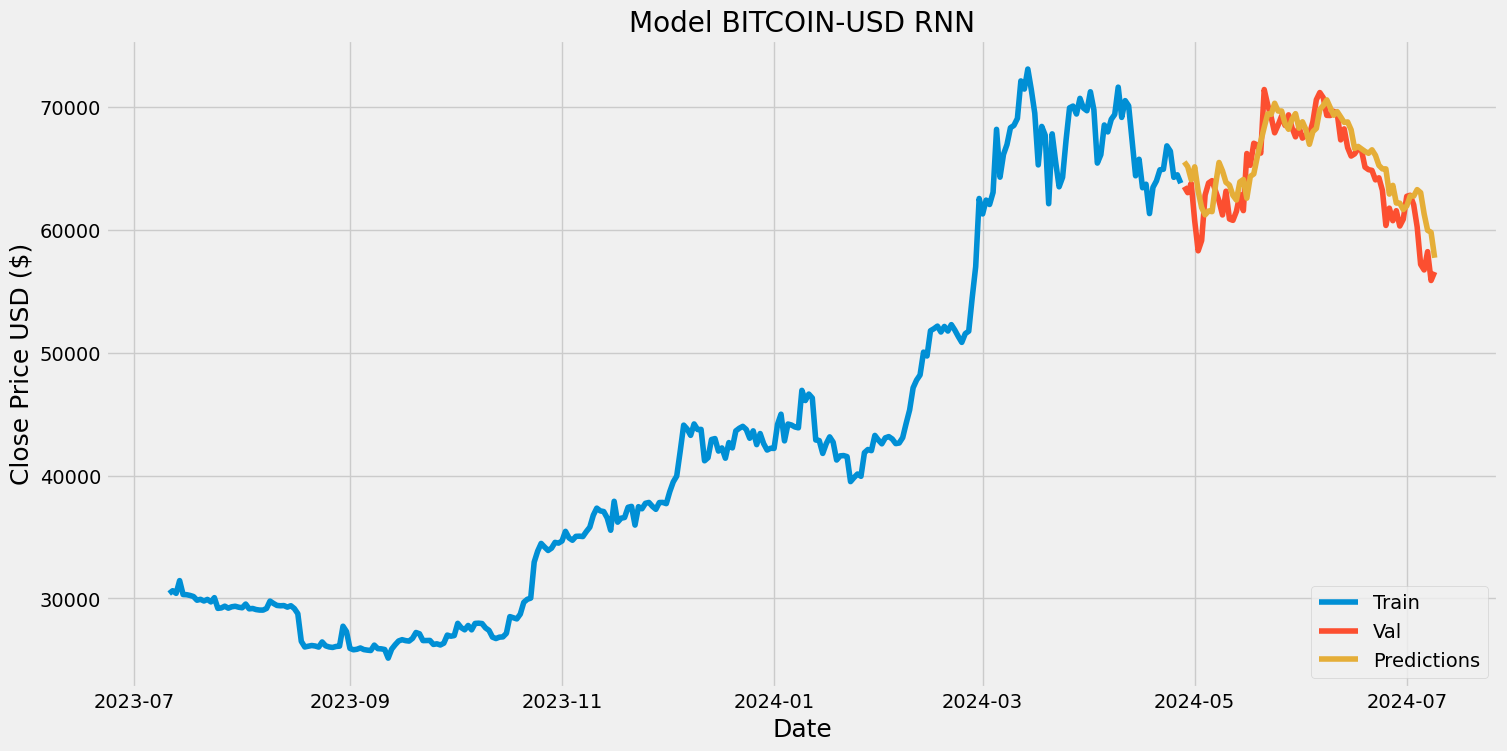

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24376\3126603917.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Date'] = valid.index


BITCOIN-USD RNN RMSE: 2100.2445063589807
BITCOIN-USD RNN MAE: 1659.3325002302515
BITCOIN-USD RNN MAPE: 2.643463492328451%
Epoch 1/10


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.2026
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0923
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0677
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0609
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0440
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0349
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0317
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0225
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0333
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0227
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24376\3126603917.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


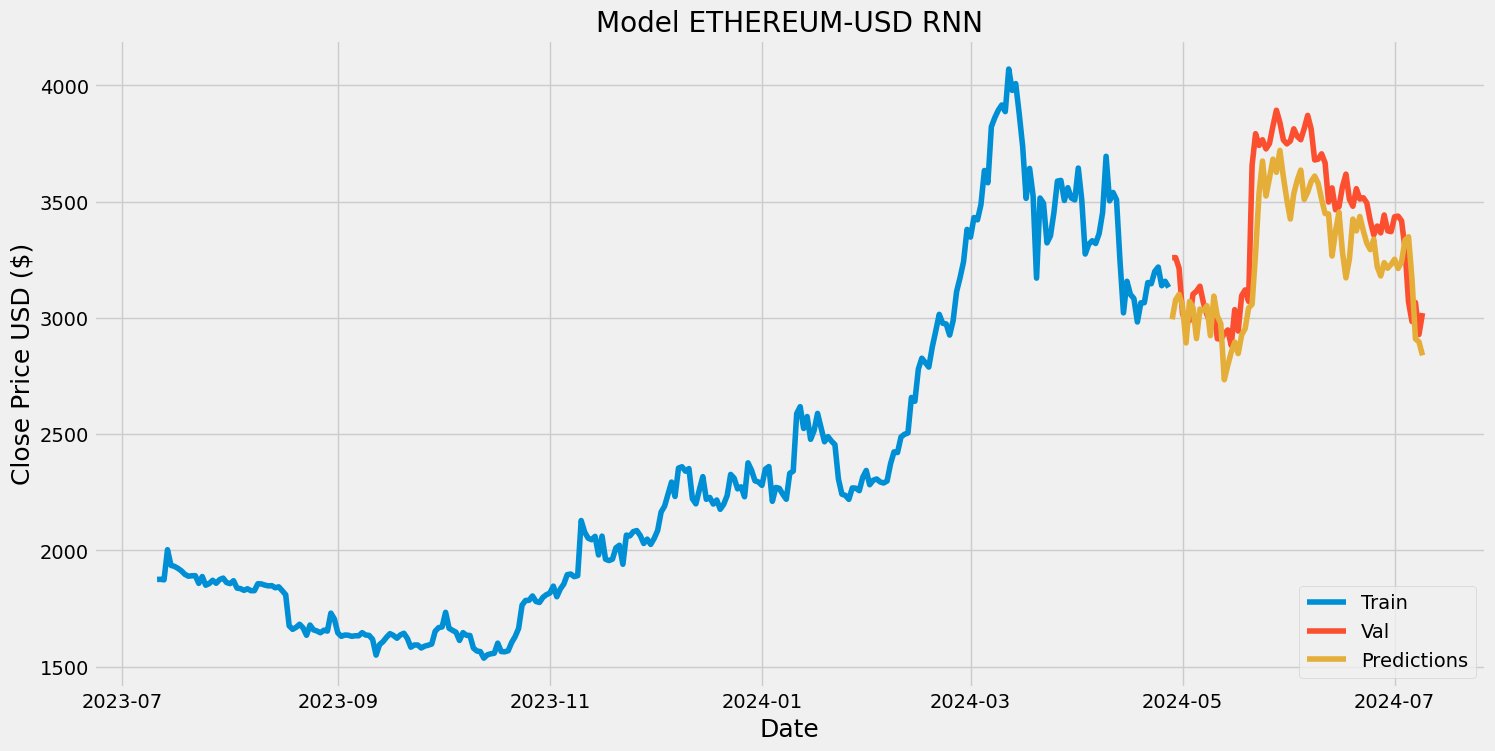

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24376\3126603917.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Date'] = valid.index


ETHEREUM-USD RNN RMSE: 198.20994753675495
ETHEREUM-USD RNN MAE: 164.9948243149953
ETHEREUM-USD RNN MAPE: 4.764603271078878%
Epoch 1/10


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.7321
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2391
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2053
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1180
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1033
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0899
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0707
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0489
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0505
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0339
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24376\3126603917.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


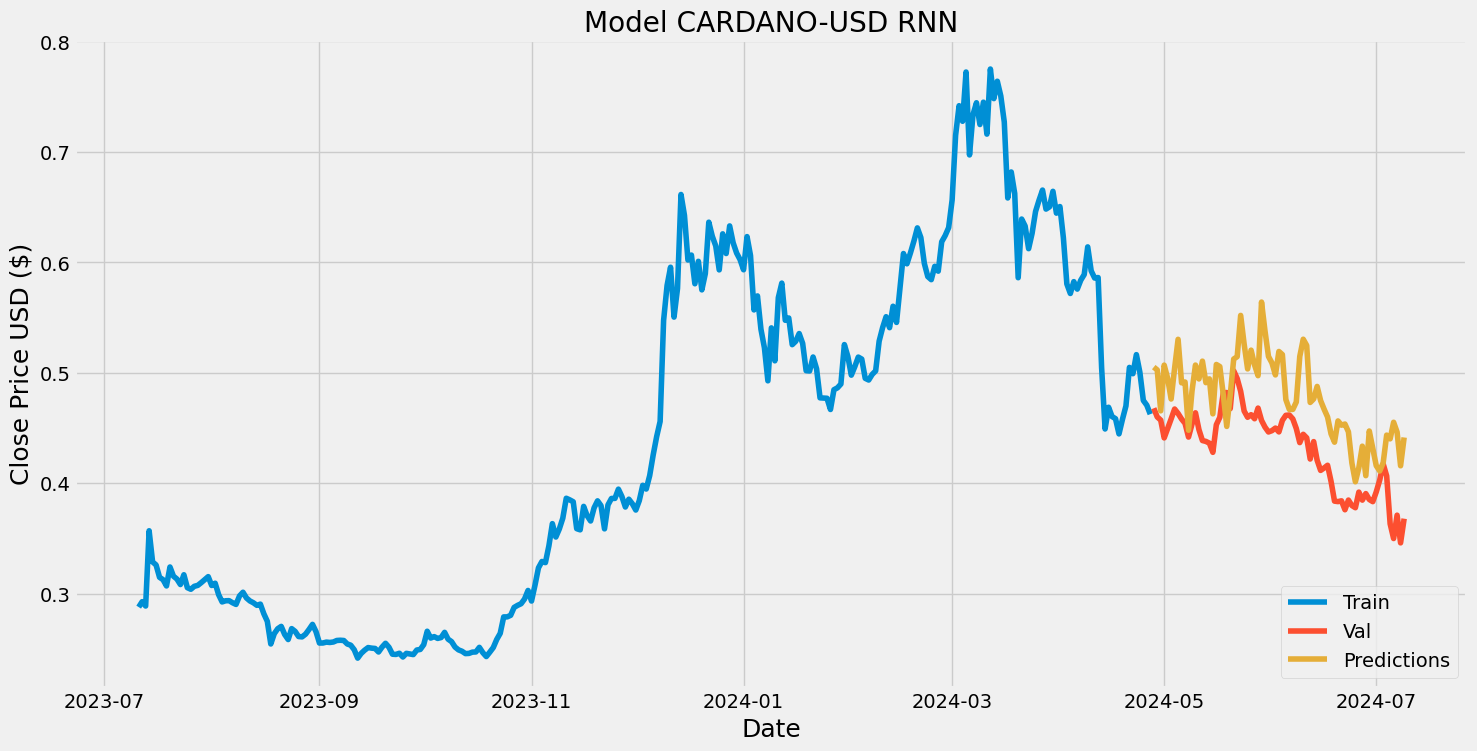

CARDANO-USD RNN RMSE: 0.053343901513396186
CARDANO-USD RNN MAE: 0.04724981645751853
CARDANO-USD RNN MAPE: 11.196115978260618%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24376\3126603917.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Date'] = valid.index


In [11]:
# Dự đoán và lưu kết quả cho BTC-USD
predict_and_save('bitcoin', 'usd', '365', '../output/RNN/BTC-USD.csv')

# Dự đoán và lưu kết quả cho ETH-USD
predict_and_save('ethereum', 'usd', '365', '../output/RNN/ETH-USD.csv')

# Dự đoán và lưu kết quả cho ADA-USD
predict_and_save('cardano', 'usd', '365', '../output/RNN/ADA-USD.csv')